# Importing Libraries

In [275]:
import spacy
import csv
import pandas as pd
from collections import Counter
from spacytextblob.spacytextblob import SpacyTextBlob
import numpy as np
import matplotlib.pyplot as plt
import pickle
from wordcloud import WordCloud
import itertools
import seaborn as sns
import math

# Importing Dataset

In [2]:
# importing dataset
bank_df = pd.read_csv('bank_scraped_data.csv')
bank_df.head(5)

,company,rating,date,title,text,company_reply,user_url,user_num_reviews,user_geo_location
0,Monzo,Rated 5 out of 5 stars,2022-06-10T09:22:08.000Z,One of the first to make good use of…,One of the first to make good use of technolog...,NaN,/users/5e8c6423b539f395afdff62d,12,GB
1,Monzo,Rated 1 out of 5 stars,2022-06-10T09:20:08.000Z,Stop texting my 11 year old requesting money,"While I'm not a customer, my 11 year old daugh...",NaN,/users/62a2f09f0ca7ed001272a232,1,GB
2,Monzo,Rated 1 out of 5 stars,2022-06-10T00:35:34.000Z,I am shocked by the ignorance of the…,I am shocked by the ignorance of the customer ...,NaN,/users/5e10fbe5361d61898f0d07be,7,CZ
3,Monzo,Rated 1 out of 5 stars,2022-06-09T21:45:13.000Z,Terrible Support,Complete waste of time. Try and get some suppo...,NaN,/users/5ec53f30ee8f29789fd5c151,2,GB
4,Monzo,Rated 5 out of 5 stars,2022-06-09T21:25:10.000Z,Monzo is the first bank we use in UK,Monzo is the first bank we use in UK. Great! T...,NaN,/users/62514fec30e1fa0012d654be,4,GB


# Splitting Dataframe by Company

In [292]:
monzo_df = bank_df.loc[bank_df['company'] == "Monzo"]
sb_df = bank_df.loc[bank_df['company'] == "Starling Bank"]
wise_df = bank_df.loc[bank_df['company'] == "Wise (formerly TransferWise)"]
rev_df = bank_df.loc[bank_df['company'] == "Revolut"]

monzo_df = monzo_df[monzo_df["date"].notna()].reset_index(drop=True)
sb_df = sb_df[sb_df["date"].notna()].reset_index(drop=True)
wise_df = wise_df[wise_df["date"].notna()].reset_index(drop=True)
rev_df = rev_df[rev_df["date"].notna()].reset_index(drop=True)

print("Monzo Dataframe Length = {}".format(len(monzo_df)))
print("Starling Bank Dataframe Length = {}".format(len(sb_df)))
print("Wise Dataframe Length = {}".format(len(wise_df)))
print("Revolut Dataframe Length = {}".format(len(rev_df)))

Monzo Dataframe Length = 20486
Starling Bank Dataframe Length = 27619
Wise Dataframe Length = 129503
Revolut Dataframe Length = 86474


In [286]:
# loading textual fields for EDA
# monzo
monzo_review_rating = monzo_df["rating"]
monzo_review_title = monzo_df["title"]
monzo_review_text = monzo_df["text"]
monzo_review_date = monzo_df["date"]

# starling bank
sb_review_rating = sb_df["rating"]
sb_review_title = sb_df["title"]
sb_review_text = sb_df["text"]
sb_review_date = sb_df["date"]

# wise
wise_review_rating = wise_df["rating"]
wise_review_title = wise_df["title"]
wise_review_text = wise_df["text"]
wise_review_date = wise_df["date"]

# revolut
rev_review_rating = rev_df["rating"]
rev_review_title = rev_df["title"]
rev_review_text = rev_df["text"]
rev_review_date = rev_df["date"]

# EDA (Pre-Processing)

## Overview

In [488]:
# getting axes for timeseries (finding earliest and latest date)
monzo_start_review_date_split =  monzo_review_date.iloc[-1].split("-")
monzo_end_review_date_split =  monzo_review_date.iloc[0].split("-")

sb_start_review_date_split =  sb_review_date.iloc[-2].split("-")
sb_end_review_date_split =  sb_review_date.iloc[0].split("-")

wise_start_review_date_split =  wise_review_date.iloc[-1].split("-")
wise_end_review_date_split =  wise_review_date.iloc[0].split("-")

rev_start_review_date_split =  rev_review_date.iloc[-1].split("-")
rev_end_review_date_split =  rev_review_date.iloc[0].split("-")

# earliest date
start_year = int(min(monzo_start_review_date_split[0], sb_start_review_date_split[0], wise_start_review_date_split[0], rev_start_review_date_split[0]))

# latest date
end_year = int(max(monzo_end_review_date_split[0], sb_end_review_date_split[0], wise_end_review_date_split[0], rev_end_review_date_split[0]))

# getting x axis (YY-MM date)
dates = []
for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        if year == 2022 and month == 7:
            break
        else:
            if month < 10:
                dates.append("{0}-0{1}".format(year, month))
            else:
                dates.append("{0}-{1}".format(year, month))

# getting start date for each bank for MA
monzo_start_month = monzo_start_review_date_split[0] + "-" + monzo_start_review_date_split[1]
sb_start_month = sb_start_review_date_split[0] + "-" + sb_start_review_date_split[1]
wise_start_month = wise_start_review_date_split[0] + "-" + wise_start_review_date_split[1]
rev_start_month = rev_start_review_date_split[0] + "-" + rev_start_review_date_split[1]

# getting corresponding index of the start dates
monzo_start_index = dates.index(monzo_start_month)
sb_start_index = dates.index(sb_start_month)
wise_start_index = dates.index(wise_start_month)
rev_start_index = dates.index(rev_start_month)

In [350]:
# for timeseries plots
################################ Monzo #######################################
monzo_freq_review_date = []
monzo_avg_review_length = []
monzo_avg_review_rating = []

# iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
for date in dates:
    review_length_total = 0 # to tally review lengths
    rating_total = 0 # to tally review ratings
#     date_match = date[:7] # date to consider
    filtered_monzo_df = monzo_df[monzo_df["yy_mm_date"] == date] # getting all reviews that was posted in the given year and month
    num_reviews = len(filtered_monzo_df) 
    
    # iterating over each review to get cumulative sum
    for i in range(num_reviews):
        
        if pd.isnull(filtered_monzo_df.iloc[i, 4]):
            review_length_total += 0
        else:
            review_length_total += len(filtered_monzo_df.iloc[i, 4])
            rating_total += int(filtered_monzo_df.iloc[i, 1].split(" ")[1])
        
    # getting frequency, average review lengths and average review ratings
    monzo_freq_review_date.append(num_reviews)
    if num_reviews != 0:
        monzo_avg_review_length.append(review_length_total/num_reviews)
        monzo_avg_review_rating.append(rating_total/num_reviews)
    else:
        monzo_avg_review_length.append(0)
        monzo_avg_review_rating.append(0)        

# getting min-max dist of reviews
monzo_freq_dist_review_date = [(freq - min(monzo_freq_review_date))/(max(monzo_freq_review_date) - min(monzo_freq_review_date)) for freq in monzo_freq_review_date]

################################ Starling Bank #######################################
sb_freq_review_date = []
sb_avg_review_length = []
sb_avg_review_rating = []

# iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
for date in dates:
    review_length_total = 0 # to tally review lengths
    rating_total = 0 # to tally review ratings
#     date_match = date[:7] # date to consider
    filtered_sb_df = sb_df[sb_df["yy_mm_date"] == date] # getting all reviews that was posted in the given year and month
    num_reviews = len(filtered_sb_df) 
    
    # iterating over each review to get cumulative sum
    for i in range(num_reviews):
        
        if pd.isnull(filtered_sb_df.iloc[i, 4]):
            review_length_total += 0
        else:
            review_length_total += len(filtered_sb_df.iloc[i, 4])
            rating_total += int(filtered_sb_df.iloc[i, 1].split(" ")[1])
        
    # getting frequency, average review lengths and average review ratings
    sb_freq_review_date.append(num_reviews)
    if num_reviews != 0:
        sb_avg_review_length.append(review_length_total/num_reviews)
        sb_avg_review_rating.append(rating_total/num_reviews)
    else:
        sb_avg_review_length.append(0)
        sb_avg_review_rating.append(0)        

# getting min-max dist of reviews
sb_freq_dist_review_date = [(freq - min(sb_freq_review_date))/(max(sb_freq_review_date) - min(sb_freq_review_date)) for freq in sb_freq_review_date]

################################ Wise #######################################
wise_freq_review_date = []
wise_avg_review_length = []
wise_avg_review_rating = []

# iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
for date in dates:
    review_length_total = 0 # to tally review lengths
    rating_total = 0 # to tally review ratings
#     date_match = date[:7] # date to consider
    filtered_wise_df = wise_df[wise_df["yy_mm_date"] == date] # getting all reviews that was posted in the given year and month
    num_reviews = len(filtered_wise_df) 
    
    # iterating over each review to get cumulative sum
    for i in range(num_reviews):
        
        if pd.isnull(filtered_wise_df.iloc[i, 4]):
            review_length_total += 0
        else:
            review_length_total += len(filtered_wise_df.iloc[i, 4])
            rating_total += int(filtered_wise_df.iloc[i, 1].split(" ")[1])
        
    # getting frequency, average review lengths and average review ratings
    wise_freq_review_date.append(num_reviews)
    if num_reviews != 0:
        wise_avg_review_length.append(review_length_total/num_reviews)
        wise_avg_review_rating.append(rating_total/num_reviews)
    else:
        wise_avg_review_length.append(0)
        wise_avg_review_rating.append(0)        

# getting min-max dist of reviews
wise_freq_dist_review_date = [(freq - min(wise_freq_review_date))/(max(wise_freq_review_date) - min(wise_freq_review_date)) for freq in wise_freq_review_date]

################################ Revolut #######################################
rev_freq_review_date = []
rev_avg_review_length = []
rev_avg_review_rating = []

# iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
for date in dates:
    review_length_total = 0 # to tally review lengths
    rating_total = 0 # to tally review ratings
    date_match = date[:7] # date to consider
    filtered_rev_df = rev_df[rev_df["yy_mm_date"] == date] # getting all reviews that was posted in the given year and month
    num_reviews = len(filtered_rev_df) 
    
    # iterating over each review to get cumulative sum
    for i in range(num_reviews):
        
        if pd.isnull(filtered_rev_df.iloc[i, 4]):
            review_length_total += 0
        else:
            review_length_total += len(filtered_rev_df.iloc[i, 4])
            rating_total += int(filtered_rev_df.iloc[i, 1].split(" ")[1])
        
    # getting frequency, average review lengths and average review ratings
    rev_freq_review_date.append(num_reviews)
    if num_reviews != 0:
        rev_avg_review_length.append(review_length_total/num_reviews)
        rev_avg_review_rating.append(rating_total/num_reviews)
    else:
        rev_avg_review_length.append(0)
        rev_avg_review_rating.append(0)        

# getting min-max dist of reviews
rev_freq_dist_review_date = [(freq - min(rev_freq_review_date))/(max(rev_freq_review_date) - min(rev_freq_review_date)) for freq in rev_freq_review_date]

In [497]:
# for moving average plots

n_month_ma = 3
monzo_avg_review_length_ma = []
monzo_avg_review_rating_ma = []
sb_avg_review_length_ma = []
sb_avg_review_rating_ma = []
wise_avg_review_length_ma = []
wise_avg_review_rating_ma = []
rev_avg_review_length_ma = []
rev_avg_review_rating_ma = []

for i in range(len(dates)):
    # monzo
    if i >= monzo_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += monzo_avg_review_length[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += monzo_avg_review_rating[i - j] # summing up previous n_month_ma number of average reviews
        monzo_avg_review_length_ma.append(avg_length_ma/n_month_ma)
        monzo_avg_review_rating_ma.append(avg_rating_ma/n_month_ma)
    else:
        monzo_avg_review_length_ma.append(0)
        monzo_avg_review_rating_ma.append(0)
    
    # starling bank
    if i >= sb_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += sb_avg_review_length[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += sb_avg_review_rating[i - j] # summing up previous n_month_ma number of average reviews
        sb_avg_review_length_ma.append(avg_length_ma/n_month_ma)
        sb_avg_review_rating_ma.append(avg_rating_ma/n_month_ma)
    else:
        sb_avg_review_length_ma.append(0)
        sb_avg_review_rating_ma.append(0)
    
    # wise
    if i >= wise_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += wise_avg_review_length[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += wise_avg_review_rating[i - j] # summing up previous n_month_ma number of average reviews
        wise_avg_review_length_ma.append(avg_length_ma/n_month_ma)
        wise_avg_review_rating_ma.append(avg_rating_ma/n_month_ma)
    else:
        wise_avg_review_length_ma.append(0)
        wise_avg_review_rating_ma.append(0)
    
    # revolut
    if i >= rev_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += rev_avg_review_length[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += rev_avg_review_rating[i - j] # summing up previous n_month_ma number of average reviews
        rev_avg_review_length_ma.append(avg_length_ma/n_month_ma)
        rev_avg_review_rating_ma.append(avg_rating_ma/n_month_ma)
    else:
        rev_avg_review_length_ma.append(0)
        rev_avg_review_rating_ma.append(0)
    

## Time Series EDA Plots

## Averages Over Time

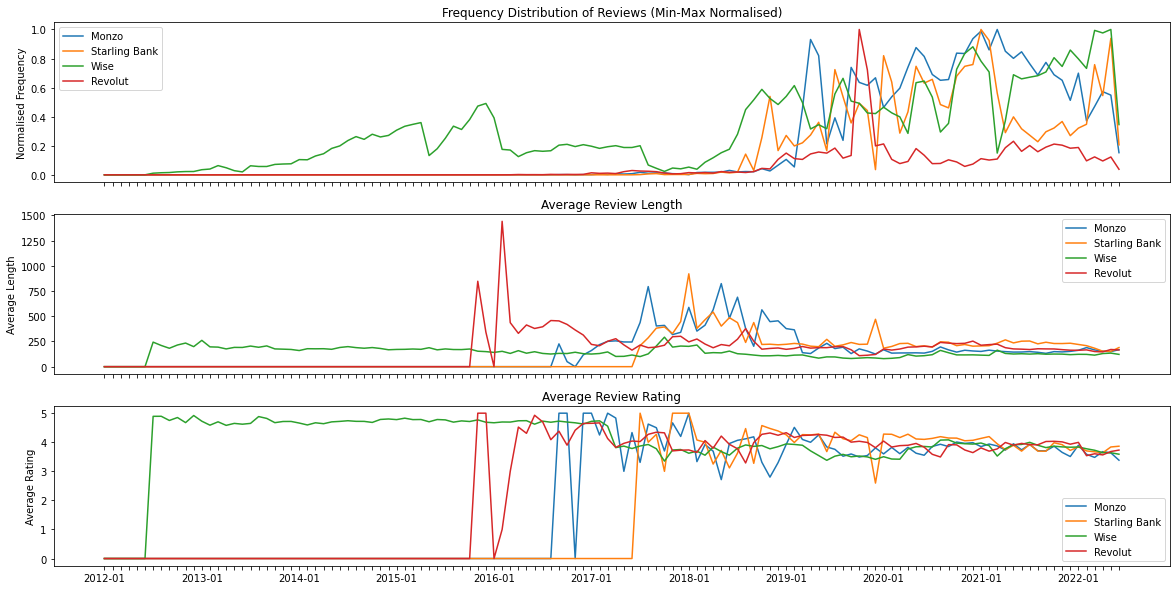

In [476]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))

ax[0].title.set_text('Frequency Distribution of Reviews (Min-Max Normalised)')
ax[0].plot(dates, monzo_freq_dist_review_date, label="Monzo")
# ax[0].set_xlim(monzo_start_date, '2022-06')
ax[0].plot(dates, sb_freq_dist_review_date, label="Starling Bank")
ax[0].plot(dates, wise_freq_dist_review_date, label="Wise")
ax[0].plot(dates, rev_freq_dist_review_date, label="Revolut")
ax[0].legend()
ax[0].set_xticklabels([])
ax[0].set_ylabel("Normalised Frequency")

ax[1].title.set_text('Average Review Length')
ax[1].plot(dates, monzo_avg_review_length, label="Monzo")
ax[1].plot(dates, sb_avg_review_length, label="Starling Bank")
ax[1].plot(dates, wise_avg_review_length, label="Wise")
ax[1].plot(dates, rev_avg_review_length, label="Revolut")
ax[1].legend()
ax[1].set_xticklabels([])
ax[1].set_ylabel("Average Length")

ax[2].title.set_text('Average Review Rating')
ax[2].plot(dates, monzo_avg_review_rating, label="Monzo")
ax[2].plot(dates, sb_avg_review_rating, label="Starling Bank")
ax[2].plot(dates, wise_avg_review_rating, label="Wise")
ax[2].plot(dates, rev_avg_review_rating, label="Revolut")
ax[2].legend()
ax[2].set_ylabel("Average Rating")

every_nth = 12
for n, label in enumerate(ax[2].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)


## Moving Averages

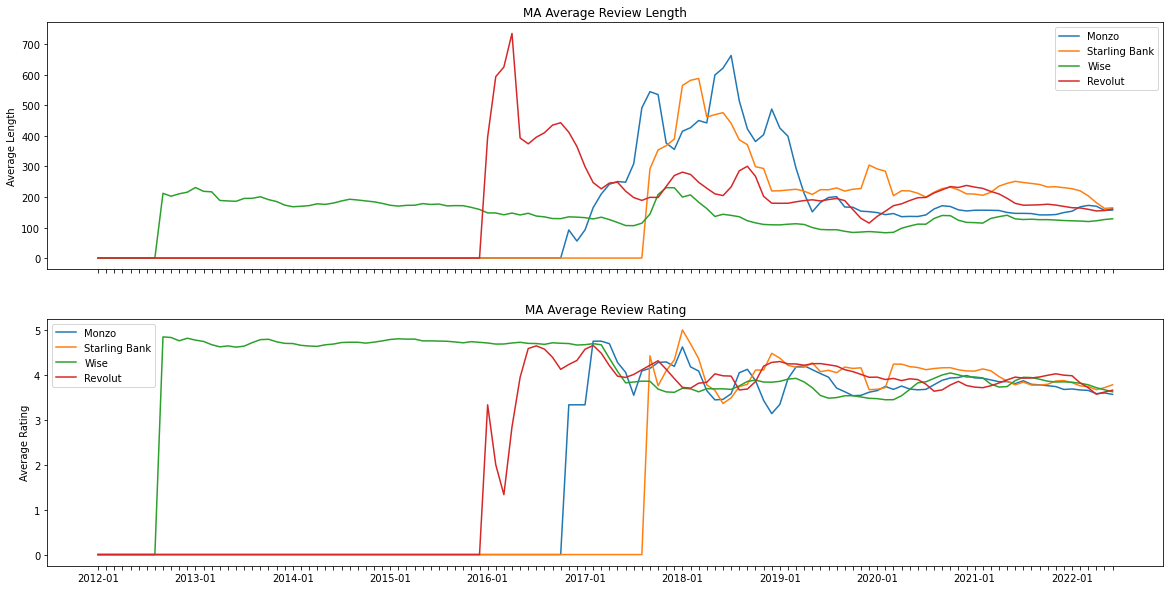

In [501]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].title.set_text('MA Average Review Length')
ax[0].plot(dates, monzo_avg_review_length_ma, label="Monzo")
ax[0].plot(dates, sb_avg_review_length_ma, label="Starling Bank")
ax[0].plot(dates, wise_avg_review_length_ma, label="Wise")
ax[0].plot(dates, rev_avg_review_length_ma, label="Revolut")
ax[0].legend()
ax[0].set_xticklabels([])
ax[0].set_ylabel("Average Length")

ax[1].title.set_text('MA Average Review Rating')
ax[1].plot(dates, monzo_avg_review_rating_ma, label="Monzo")
ax[1].plot(dates, sb_avg_review_rating_ma, label="Starling Bank")
ax[1].plot(dates, wise_avg_review_rating_ma, label="Wise")
ax[1].plot(dates, rev_avg_review_rating_ma, label="Revolut")
ax[1].legend()
ax[1].set_ylabel("Average Rating")

every_nth = 12
for n, label in enumerate(ax[1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

## Granular

## Splitting by Poor and Good Ratings

In [469]:
################################### Monzo ###############################################################################
monzo_df_poor = monzo_df.loc[(monzo_df['rating'] == 'Rated 1 out of 5 stars') | (monzo_df['rating'] == 'Rated 2 out of 5 stars') | (monzo_df['rating'] == 'Rated 3 out of 5 stars')]
monzo_df_good = monzo_df.loc[(monzo_df['rating'] == 'Rated 4 out of 5 stars') | (monzo_df['rating'] == 'Rated 5 out of 5 stars')]

################################### Starling Bank #######################################################################
sb_df_poor = sb_df.loc[(sb_df['rating'] == 'Rated 1 out of 5 stars') | (sb_df['rating'] == 'Rated 2 out of 5 stars') | (sb_df['rating'] == 'Rated 3 out of 5 stars')]
sb_df_good = sb_df.loc[(sb_df['rating'] == 'Rated 4 out of 5 stars') | (sb_df['rating'] == 'Rated 5 out of 5 stars')]

################################### Wise #######################################################################
wise_df_poor = wise_df.loc[(wise_df['rating'] == 'Rated 1 out of 5 stars') | (wise_df['rating'] == 'Rated 2 out of 5 stars') | (wise_df['rating'] == 'Rated 3 out of 5 stars')]
wise_df_good = wise_df.loc[(wise_df['rating'] == 'Rated 4 out of 5 stars') | (wise_df['rating'] == 'Rated 5 out of 5 stars')]


################################### Revolut #######################################################################
rev_df_poor = rev_df.loc[(rev_df['rating'] == 'Rated 1 out of 5 stars') | (rev_df['rating'] == 'Rated 2 out of 5 stars') | (rev_df['rating'] == 'Rated 3 out of 5 stars')]
rev_df_good = rev_df.loc[(rev_df['rating'] == 'Rated 4 out of 5 stars') | (rev_df['rating'] == 'Rated 5 out of 5 stars')]

In [410]:
# retrieving textual fields for EDA
# Monzo
monzo_review_rating_poor = monzo_df_poor["rating"]
monzo_review_text_poor = monzo_df_poor["text"]
monzo_review_date_poor = monzo_df_poor["yy_mm_date"]

monzo_review_rating_good = monzo_df_good["rating"]
monzo_review_text_good = monzo_df_good["text"]
monzo_review_date_good = monzo_df_good["yy_mm_date"]

# Starling Bank
sb_review_rating_poor = sb_df_poor["rating"]
sb_review_text_poor = sb_df_poor["text"]
sb_review_date_poor = sb_df_poor["yy_mm_date"]

sb_review_rating_good = sb_df_good["rating"]
sb_review_text_good = sb_df_good["text"]
sb_review_date_good = sb_df_good["yy_mm_date"]

# Wise
wise_review_rating_poor = wise_df_poor["rating"]
wise_review_text_poor = wise_df_poor["text"]
wise_review_date_poor = wise_df_poor["yy_mm_date"]

wise_review_rating_good = wise_df_good["rating"]
wise_review_text_good = wise_df_good["text"]
wise_review_date_good = wise_df_good["yy_mm_date"]

# Revolut
rev_review_rating_poor = rev_df_poor["rating"]
rev_review_text_poor = rev_df_poor["text"]
rev_review_date_poor = rev_df_poor["yy_mm_date"]

rev_review_rating_good = rev_df_good["rating"]
rev_review_text_good = rev_df_good["text"]
rev_review_date_good = rev_df_good["yy_mm_date"]


In [421]:
################################ Monzo #######################################
monzo_freq_review_date_poor = []
monzo_avg_review_length_poor = []
monzo_avg_review_rating_poor = []

monzo_freq_review_date_good = []
monzo_avg_review_length_good = []
monzo_avg_review_rating_good = []

# iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
for date in dates:
    
    # poor
    review_length_total_poor = 0 # to tally review lengths
    rating_total_poor = 0 # to tally review ratings
    filtered_monzo_df_poor = monzo_df_poor[monzo_review_date_poor == date] # getting all poor reviews that was posted in the given year and month
    num_reviews_poor = len(filtered_monzo_df_poor) 
    
    # good
    review_length_total_good = 0 # to tally review lengths
    rating_total_good = 0 # to tally review ratings
    filtered_monzo_df_good = monzo_df_good[monzo_review_date_good == date] # getting all poor reviews that was posted in the given year and month
    num_reviews_good = len(filtered_monzo_df_good) 
    
    # iterating over each review to get cumulative sum
    # poor
    for i in range(num_reviews_poor):
        if pd.isnull(filtered_monzo_df_poor.iloc[i, 4]):
            review_length_total_poor += 0
        else:
            review_length_total_poor += len(filtered_monzo_df_poor.iloc[i, 4])
            rating_total_poor += int(filtered_monzo_df_poor.iloc[i, 1].split(" ")[1])

    # good
    for i in range(num_reviews_good):
        if pd.isnull(filtered_monzo_df_good.iloc[i, 4]):
            review_length_total_good += 0
        else:
            review_length_total_good += len(filtered_monzo_df_good.iloc[i, 4])
            rating_total_good += int(filtered_monzo_df_good.iloc[i, 1].split(" ")[1])
            
    # getting frequency, average review lengths and average review ratings
    
    # poor
    monzo_freq_review_date_poor.append(num_reviews_poor)
    if num_reviews_poor != 0:
        monzo_avg_review_length_poor.append(review_length_total_poor/num_reviews_poor)
        monzo_avg_review_rating_poor.append(rating_total_poor/num_reviews_poor)
    else:
        monzo_avg_review_length_poor.append(0)
        monzo_avg_review_rating_poor.append(0)    
    
    # good
    monzo_freq_review_date_good.append(num_reviews_good)
    if num_reviews_good != 0:
        monzo_avg_review_length_good.append(review_length_total_good/num_reviews_good)
        monzo_avg_review_rating_good.append(rating_total_good/num_reviews_good)
    else:
        monzo_avg_review_length_good.append(0)
        monzo_avg_review_rating_good.append(0)        


# getting min-max dist of reviews
monzo_freq_dist_review_date_poor = [(freq - min(monzo_freq_review_date_poor))/(max(monzo_freq_review_date_poor) - min(monzo_freq_review_date_poor)) for freq in monzo_freq_review_date_poor]
monzo_freq_dist_review_date_good = [(freq - min(monzo_freq_review_date_good))/(max(monzo_freq_review_date_good) - min(monzo_freq_review_date_good)) for freq in monzo_freq_review_date_good]

################################ Starling Bank #######################################
sb_freq_review_date_poor = []
sb_avg_review_length_poor = []
sb_avg_review_rating_poor = []

sb_freq_review_date_good = []
sb_avg_review_length_good = []
sb_avg_review_rating_good = []

# iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
for date in dates:
    
    # poor
    review_length_total_poor = 0 # to tally review lengths
    rating_total_poor = 0 # to tally review ratings
    filtered_sb_df_poor = sb_df_poor[sb_review_date_poor == date] # getting all poor reviews that was posted in the given year and month
    num_reviews_poor = len(filtered_sb_df_poor) 
    
    # good
    review_length_total_good = 0 # to tally review lengths
    rating_total_good = 0 # to tally review ratings
    filtered_sb_df_good = sb_df_good[sb_review_date_good == date] # getting all poor reviews that was posted in the given year and month
    num_reviews_good = len(filtered_sb_df_good) 
    
    # iterating over each review to get cumulative sum
    # poor
    for i in range(num_reviews_poor):
        if pd.isnull(filtered_sb_df_poor.iloc[i, 4]):
            review_length_total_poor += 0
        else:
            review_length_total_poor += len(filtered_sb_df_poor.iloc[i, 4])
            rating_total_poor += int(filtered_sb_df_poor.iloc[i, 1].split(" ")[1])

    # good
    for i in range(num_reviews_good):
        if pd.isnull(filtered_sb_df_good.iloc[i, 4]):
            review_length_total_good += 0
        else:
            review_length_total_good += len(filtered_sb_df_good.iloc[i, 4])
            rating_total_good += int(filtered_sb_df_good.iloc[i, 1].split(" ")[1])
            
    # getting frequency, average review lengths and average review ratings
    
    # poor
    sb_freq_review_date_poor.append(num_reviews_poor)
    if num_reviews_poor != 0:
        sb_avg_review_length_poor.append(review_length_total_poor/num_reviews_poor)
        sb_avg_review_rating_poor.append(rating_total_poor/num_reviews_poor)
    else:
        sb_avg_review_length_poor.append(0)
        sb_avg_review_rating_poor.append(0)    
    
    # good
    sb_freq_review_date_good.append(num_reviews_good)
    if num_reviews_good != 0:
        sb_avg_review_length_good.append(review_length_total_good/num_reviews_good)
        sb_avg_review_rating_good.append(rating_total_good/num_reviews_good)
    else:
        sb_avg_review_length_good.append(0)
        sb_avg_review_rating_good.append(0)        


# getting min-max dist of reviews
sb_freq_dist_review_date_poor = [(freq - min(sb_freq_review_date_poor))/(max(sb_freq_review_date_poor) - min(sb_freq_review_date_poor)) for freq in sb_freq_review_date_poor]
sb_freq_dist_review_date_good = [(freq - min(sb_freq_review_date_good))/(max(sb_freq_review_date_good) - min(sb_freq_review_date_good)) for freq in sb_freq_review_date_good]

################################ Wise #######################################
wise_freq_review_date_poor = []
wise_avg_review_length_poor = []
wise_avg_review_rating_poor = []

wise_freq_review_date_good = []
wise_avg_review_length_good = []
wise_avg_review_rating_good = []

# iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
for date in dates:
    
    # poor
    review_length_total_poor = 0 # to tally review lengths
    rating_total_poor = 0 # to tally review ratings
    filtered_wise_df_poor = wise_df_poor[wise_review_date_poor == date] # getting all poor reviews that was posted in the given year and month
    num_reviews_poor = len(filtered_wise_df_poor) 
    
    # good
    review_length_total_good = 0 # to tally review lengths
    rating_total_good = 0 # to tally review ratings
    filtered_wise_df_good = wise_df_good[wise_review_date_good == date] # getting all poor reviews that was posted in the given year and month
    num_reviews_good = len(filtered_wise_df_good) 
    
    # iterating over each review to get cumulative sum
    # poor
    for i in range(num_reviews_poor):
        if pd.isnull(filtered_wise_df_poor.iloc[i, 4]):
            review_length_total_poor += 0
        else:
            review_length_total_poor += len(filtered_wise_df_poor.iloc[i, 4])
            rating_total_poor += int(filtered_wise_df_poor.iloc[i, 1].split(" ")[1])

    # good
    for i in range(num_reviews_good):
        if pd.isnull(filtered_wise_df_good.iloc[i, 4]):
            review_length_total_good += 0
        else:
            review_length_total_good += len(filtered_wise_df_good.iloc[i, 4])
            rating_total_good += int(filtered_wise_df_good.iloc[i, 1].split(" ")[1])
            
    # getting frequency, average review lengths and average review ratings
    
    # poor
    wise_freq_review_date_poor.append(num_reviews_poor)
    if num_reviews_poor != 0:
        wise_avg_review_length_poor.append(review_length_total_poor/num_reviews_poor)
        wise_avg_review_rating_poor.append(rating_total_poor/num_reviews_poor)
    else:
        wise_avg_review_length_poor.append(0)
        wise_avg_review_rating_poor.append(0)    
    
    # good
    wise_freq_review_date_good.append(num_reviews_good)
    if num_reviews_good != 0:
        wise_avg_review_length_good.append(review_length_total_good/num_reviews_good)
        wise_avg_review_rating_good.append(rating_total_good/num_reviews_good)
    else:
        wise_avg_review_length_good.append(0)
        wise_avg_review_rating_good.append(0)        


# getting min-max dist of reviews
wise_freq_dist_review_date_poor = [(freq - min(wise_freq_review_date_poor))/(max(wise_freq_review_date_poor) - min(wise_freq_review_date_poor)) for freq in wise_freq_review_date_poor]
wise_freq_dist_review_date_good = [(freq - min(wise_freq_review_date_good))/(max(wise_freq_review_date_good) - min(wise_freq_review_date_good)) for freq in wise_freq_review_date_good]

################################ Revolut #######################################
rev_freq_review_date_poor = []
rev_avg_review_length_poor = []
rev_avg_review_rating_poor = []

rev_freq_review_date_good = []
rev_avg_review_length_good = []
rev_avg_review_rating_good = []

# iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
for date in dates:
    
    # poor
    review_length_total_poor = 0 # to tally review lengths
    rating_total_poor = 0 # to tally review ratings
    filtered_rev_df_poor = rev_df_poor[rev_review_date_poor == date] # getting all poor reviews that was posted in the given year and month
    num_reviews_poor = len(filtered_rev_df_poor) 
    
    # good
    review_length_total_good = 0 # to tally review lengths
    rating_total_good = 0 # to tally review ratings
    filtered_rev_df_good = rev_df_good[rev_review_date_good == date] # getting all poor reviews that was posted in the given year and month
    num_reviews_good = len(filtered_rev_df_good) 
    
    # iterating over each review to get cumulative sum
    # poor
    for i in range(num_reviews_poor):
        if pd.isnull(filtered_rev_df_poor.iloc[i, 4]):
            review_length_total_poor += 0
        else:
            review_length_total_poor += len(filtered_rev_df_poor.iloc[i, 4])
            rating_total_poor += int(filtered_rev_df_poor.iloc[i, 1].split(" ")[1])

    # good
    for i in range(num_reviews_good):
        if pd.isnull(filtered_rev_df_good.iloc[i, 4]):
            review_length_total_good += 0
        else:
            review_length_total_good += len(filtered_rev_df_good.iloc[i, 4])
            rating_total_good += int(filtered_rev_df_good.iloc[i, 1].split(" ")[1])
            
    # getting frequency, average review lengths and average review ratings
    
    # poor
    rev_freq_review_date_poor.append(num_reviews_poor)
    if num_reviews_poor != 0:
        rev_avg_review_length_poor.append(review_length_total_poor/num_reviews_poor)
        rev_avg_review_rating_poor.append(rating_total_poor/num_reviews_poor)
    else:
        rev_avg_review_length_poor.append(0)
        rev_avg_review_rating_poor.append(0)    
    
    # good
    rev_freq_review_date_good.append(num_reviews_good)
    if num_reviews_good != 0:
        rev_avg_review_length_good.append(review_length_total_good/num_reviews_good)
        rev_avg_review_rating_good.append(rating_total_good/num_reviews_good)
    else:
        rev_avg_review_length_good.append(0)
        rev_avg_review_rating_good.append(0)        


# getting min-max dist of reviews
rev_freq_dist_review_date_poor = [(freq - min(rev_freq_review_date_poor))/(max(rev_freq_review_date_poor) - min(rev_freq_review_date_poor)) for freq in rev_freq_review_date_poor]
rev_freq_dist_review_date_good = [(freq - min(rev_freq_review_date_good))/(max(rev_freq_review_date_good) - min(rev_freq_review_date_good)) for freq in rev_freq_review_date_good]


In [503]:
# for moving average plots

n_month_ma = 3

# monzo
monzo_avg_review_length_poor_ma = []
monzo_avg_review_rating_poor_ma = []
monzo_avg_review_length_good_ma = []
monzo_avg_review_rating_good_ma = []

# starling bank
sb_avg_review_length_poor_ma = []
sb_avg_review_rating_poor_ma = []
sb_avg_review_length_good_ma = []
sb_avg_review_rating_good_ma = []

# wise
wise_avg_review_length_poor_ma = []
wise_avg_review_rating_poor_ma = []
wise_avg_review_length_good_ma = []
wise_avg_review_rating_good_ma = []

# revolut
rev_avg_review_length_poor_ma = []
rev_avg_review_rating_poor_ma = []
rev_avg_review_length_good_ma = []
rev_avg_review_rating_good_ma = []

for i in range(len(dates)):
    ############# monzo ###################
    # poor
    if i >= monzo_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += monzo_avg_review_length_poor[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += monzo_avg_review_rating_poor[i - j] # summing up previous n_month_ma number of average reviews
        monzo_avg_review_length_poor_ma.append(avg_length_ma/n_month_ma)
        monzo_avg_review_rating_poor_ma.append(avg_rating_ma/n_month_ma)
    else:
        monzo_avg_review_length_poor_ma.append(0)
        monzo_avg_review_rating_poor_ma.append(0)

    # good
    if i >= monzo_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += monzo_avg_review_length_good[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += monzo_avg_review_rating_good[i - j] # summing up previous n_month_ma number of average reviews
        monzo_avg_review_length_good_ma.append(avg_length_ma/n_month_ma)
        monzo_avg_review_rating_good_ma.append(avg_rating_ma/n_month_ma)
    else:
        monzo_avg_review_length_good_ma.append(0)
        monzo_avg_review_rating_good_ma.append(0)
    
    ############# starling bank ###############
    # poor
    if i >= sb_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += sb_avg_review_length_poor[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += sb_avg_review_rating_poor[i - j] # summing up previous n_month_ma number of average reviews
        sb_avg_review_length_poor_ma.append(avg_length_ma/n_month_ma)
        sb_avg_review_rating_poor_ma.append(avg_rating_ma/n_month_ma)
    else:
        sb_avg_review_length_poor_ma.append(0)
        sb_avg_review_rating_poor_ma.append(0)

    # good
    if i >= sb_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += sb_avg_review_length_good[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += sb_avg_review_rating_good[i - j] # summing up previous n_month_ma number of average reviews
        sb_avg_review_length_good_ma.append(avg_length_ma/n_month_ma)
        sb_avg_review_rating_good_ma.append(avg_rating_ma/n_month_ma)
    else:
        sb_avg_review_length_good_ma.append(0)
        sb_avg_review_rating_good_ma.append(0)

    ############# wise ###################    
    # poor
    if i >= wise_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += wise_avg_review_length_poor[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += wise_avg_review_rating_poor[i - j] # summing up previous n_month_ma number of average reviews
        wise_avg_review_length_poor_ma.append(avg_length_ma/n_month_ma)
        wise_avg_review_rating_poor_ma.append(avg_rating_ma/n_month_ma)
    else:
        wise_avg_review_length_poor_ma.append(0)
        wise_avg_review_rating_poor_ma.append(0)

    # good
    if i >= wise_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += wise_avg_review_length_good[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += wise_avg_review_rating_good[i - j] # summing up previous n_month_ma number of average reviews
        wise_avg_review_length_good_ma.append(avg_length_ma/n_month_ma)
        wise_avg_review_rating_good_ma.append(avg_rating_ma/n_month_ma)
    else:
        wise_avg_review_length_good_ma.append(0)
        wise_avg_review_rating_good_ma.append(0)
        
    ############# revolut ###################    
    # poor
    if i >= rev_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += rev_avg_review_length_poor[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += rev_avg_review_rating_poor[i - j] # summing up previous n_month_ma number of average reviews
        rev_avg_review_length_poor_ma.append(avg_length_ma/n_month_ma)
        rev_avg_review_rating_poor_ma.append(avg_rating_ma/n_month_ma)
    else:
        rev_avg_review_length_poor_ma.append(0)
        rev_avg_review_rating_poor_ma.append(0)

    # good
    if i >= rev_start_index + n_month_ma - 1:
        avg_length_ma = 0
        avg_rating_ma = 0
        for j in range(n_month_ma):
            avg_length_ma += rev_avg_review_length_good[i - j] # summing up previous n_month_ma number of average lengths
            avg_rating_ma += rev_avg_review_rating_good[i - j] # summing up previous n_month_ma number of average reviews
        rev_avg_review_length_good_ma.append(avg_length_ma/n_month_ma)
        rev_avg_review_rating_good_ma.append(avg_rating_ma/n_month_ma)
    else:
        rev_avg_review_length_good_ma.append(0)
        rev_avg_review_rating_good_ma.append(0)
    

## Granular EDA Plots

## Frequency Distribution (Pie Chart)

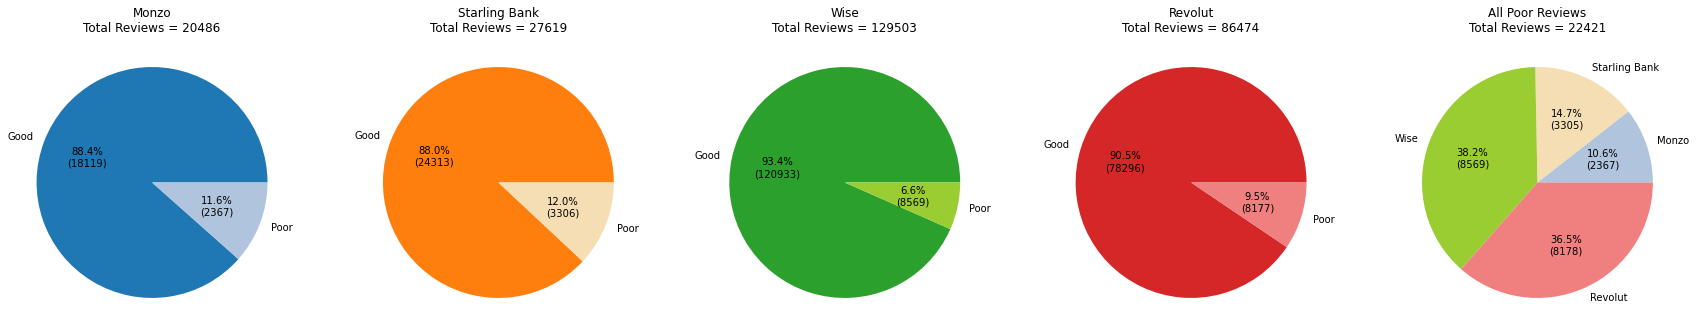

In [468]:
def label_func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

monzo_pie = [len(monzo_df_good), len(monzo_df_poor)]
sb_pie = [len(sb_df_good), len(sb_df_poor)]
wise_pie = [len(wise_df_good), len(wise_df_poor)]
rev_pie = [len(rev_df_good), len(rev_df_poor)]
all_pie = [len(monzo_df_poor), len(sb_df_poor), len(wise_df_poor), len(rev_df_poor)]

fig, ax = plt.subplots(1, 5, figsize=(30,30))

plt.title("Review Frequency Distribution")

ax[0].pie(monzo_pie, labels=["Good", "Poor"], autopct=lambda pct: label_func(pct, monzo_pie), colors=["tab:blue", "lightsteelblue"])
ax[0].title.set_text("Monzo\nTotal Reviews = {}".format(sum(monzo_pie)))

ax[1].pie(sb_pie, labels=["Good", "Poor"], autopct=lambda pct: label_func(pct, sb_pie), colors=["tab:orange", "wheat"])
ax[1].title.set_text("Starling Bank\nTotal Reviews = {}".format(sum(sb_pie)))

ax[2].pie(wise_pie, labels=["Good", "Poor"], autopct=lambda pct: label_func(pct, wise_pie), colors=["tab:green", "yellowgreen"])
ax[2].title.set_text("Wise\nTotal Reviews = {}".format(sum(wise_pie)))

ax[3].pie(rev_pie, labels=["Good", "Poor"], autopct=lambda pct: label_func(pct, rev_pie), colors=["tab:red", "lightcoral"])
ax[3].title.set_text("Revolut\nTotal Reviews = {}".format(sum(rev_pie)))

ax[4].pie(all_pie, labels=["Monzo", "Starling Bank", "Wise", "Revolut"], autopct=lambda pct: label_func(pct, all_pie), colors=["lightsteelblue", "wheat", "yellowgreen", "lightcoral"])
ax[4].title.set_text("All Poor Reviews\nTotal Reviews = {}".format(sum(all_pie)))

## Averages Over Time

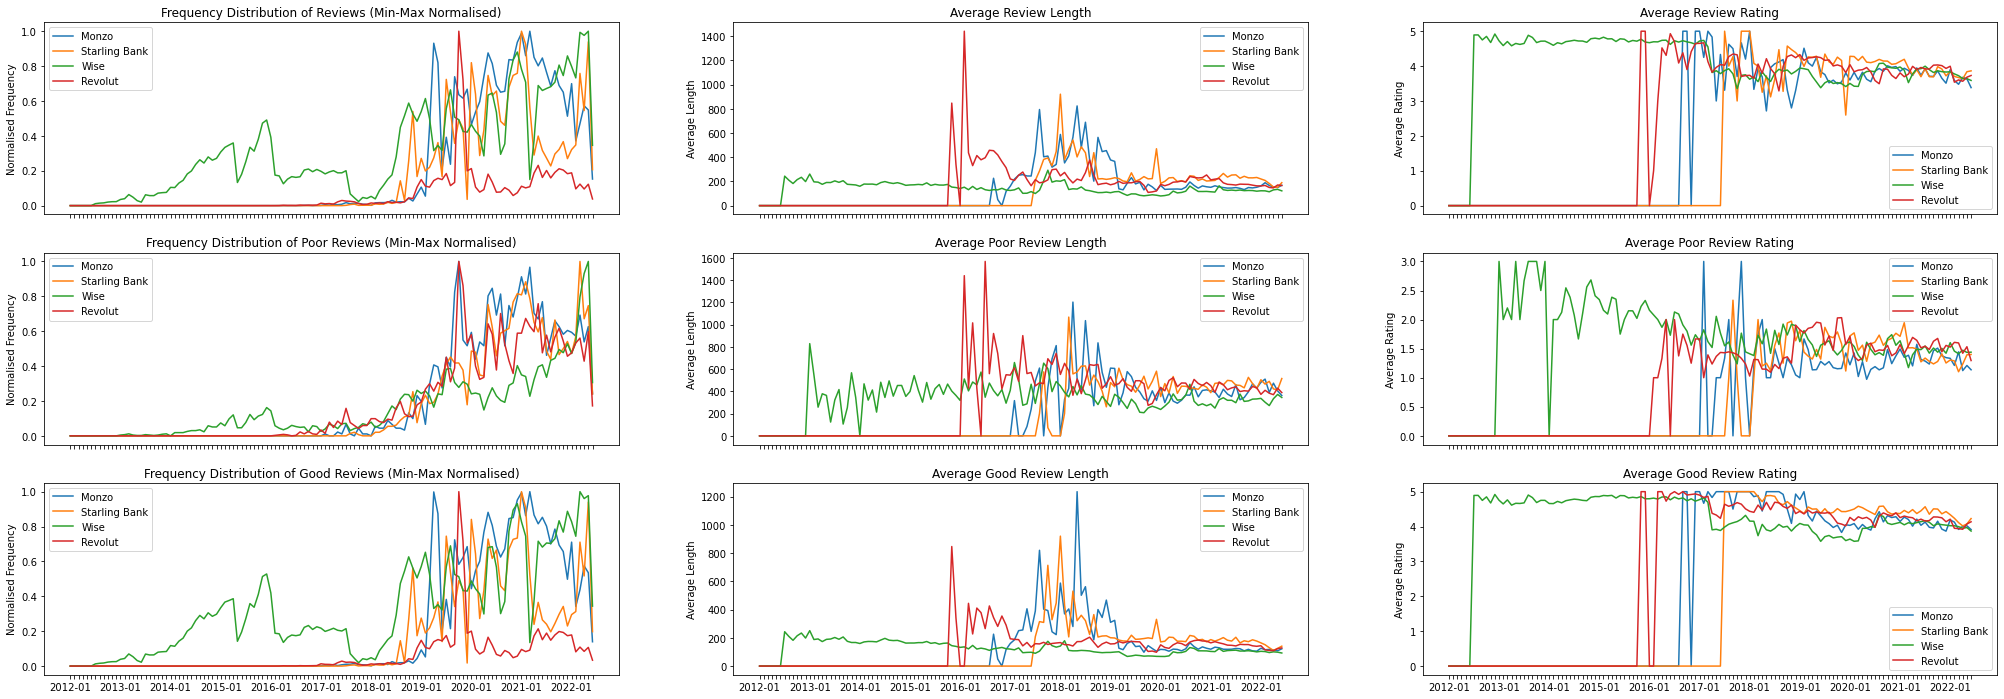

In [502]:
fig, ax = plt.subplots(3, 3, figsize=(35,12))

# Frequency Distribution
ax[0,0].title.set_text('Frequency Distribution of Reviews (Min-Max Normalised)')
ax[0,0].plot(dates, monzo_freq_dist_review_date, label="Monzo")
ax[0,0].plot(dates, sb_freq_dist_review_date, label="Starling Bank")
ax[0,0].plot(dates, wise_freq_dist_review_date, label="Wise")
ax[0,0].plot(dates, rev_freq_dist_review_date, label="Revolut")
ax[0,0].legend()
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel("Normalised Frequency")

ax[1,0].title.set_text('Frequency Distribution of Poor Reviews (Min-Max Normalised)')
ax[1,0].plot(dates, monzo_freq_dist_review_date_poor, label="Monzo")
ax[1,0].plot(dates, sb_freq_dist_review_date_poor, label="Starling Bank")
ax[1,0].plot(dates, wise_freq_dist_review_date_poor, label="Wise")
ax[1,0].plot(dates, rev_freq_dist_review_date_poor, label="Revolut")
ax[1,0].legend()
ax[1,0].set_xticklabels([])
ax[1,0].set_ylabel("Normalised Frequency")

ax[2,0].title.set_text('Frequency Distribution of Good Reviews (Min-Max Normalised)')
ax[2,0].plot(dates, monzo_freq_dist_review_date_good, label="Monzo")
ax[2,0].plot(dates, sb_freq_dist_review_date_good, label="Starling Bank")
ax[2,0].plot(dates, wise_freq_dist_review_date_good, label="Wise")
ax[2,0].plot(dates, rev_freq_dist_review_date_good, label="Revolut")
ax[2,0].legend()
ax[2,0].set_ylabel("Normalised Frequency")

every_nth = 12
for n, label in enumerate(ax[2,0].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# Average Review Length
ax[0,1].title.set_text('Average Review Length')
ax[0,1].plot(dates, monzo_avg_review_length, label="Monzo")
ax[0,1].plot(dates, sb_avg_review_length, label="Starling Bank")
ax[0,1].plot(dates, wise_avg_review_length, label="Wise")
ax[0,1].plot(dates, rev_avg_review_length, label="Revolut")
ax[0,1].legend()
ax[0,1].set_xticklabels([])
ax[0,1].set_ylabel("Average Length")

ax[1,1].title.set_text('Average Poor Review Length')
ax[1,1].plot(dates, monzo_avg_review_length_poor, label="Monzo")
ax[1,1].plot(dates, sb_avg_review_length_poor, label="Starling Bank")
ax[1,1].plot(dates, wise_avg_review_length_poor, label="Wise")
ax[1,1].plot(dates, rev_avg_review_length_poor, label="Revolut")
ax[1,1].legend()
ax[1,1].set_xticklabels([])
ax[1,1].set_ylabel("Average Length")

ax[2,1].title.set_text('Average Good Review Length')
ax[2,1].plot(dates, monzo_avg_review_length_good, label="Monzo")
ax[2,1].plot(dates, sb_avg_review_length_good, label="Starling Bank")
ax[2,1].plot(dates, wise_avg_review_length_good, label="Wise")
ax[2,1].plot(dates, rev_avg_review_length_good, label="Revolut")
ax[2,1].legend()
ax[2,1].set_ylabel("Average Length")

every_nth = 12
for n, label in enumerate(ax[2,1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# Average Review rating
ax[0,2].title.set_text('Average Review Rating')
ax[0,2].plot(dates, monzo_avg_review_rating, label="Monzo")
ax[0,2].plot(dates, sb_avg_review_rating, label="Starling Bank")
ax[0,2].plot(dates, wise_avg_review_rating, label="Wise")
ax[0,2].plot(dates, rev_avg_review_rating, label="Revolut")
ax[0,2].legend()
ax[0,2].set_xticklabels([])
ax[0,2].set_ylabel("Average Rating")

ax[1,2].title.set_text('Average Poor Review Rating')
ax[1,2].plot(dates, monzo_avg_review_rating_poor, label="Monzo")
ax[1,2].plot(dates, sb_avg_review_rating_poor, label="Starling Bank")
ax[1,2].plot(dates, wise_avg_review_rating_poor, label="Wise")
ax[1,2].plot(dates, rev_avg_review_rating_poor, label="Revolut")
ax[1,2].legend()
ax[1,2].set_xticklabels([])
ax[1,2].set_ylabel("Average Rating")

ax[2,2].title.set_text('Average Good Review Rating')
ax[2,2].plot(dates, monzo_avg_review_rating_good, label="Monzo")
ax[2,2].plot(dates, sb_avg_review_rating_good, label="Starling Bank")
ax[2,2].plot(dates, wise_avg_review_rating_good, label="Wise")
ax[2,2].plot(dates, rev_avg_review_rating_good, label="Revolut")
ax[2,2].legend()
ax[2,2].set_ylabel("Average Rating")

every_nth = 12
for n, label in enumerate(ax[2,2].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

## Moving Averages

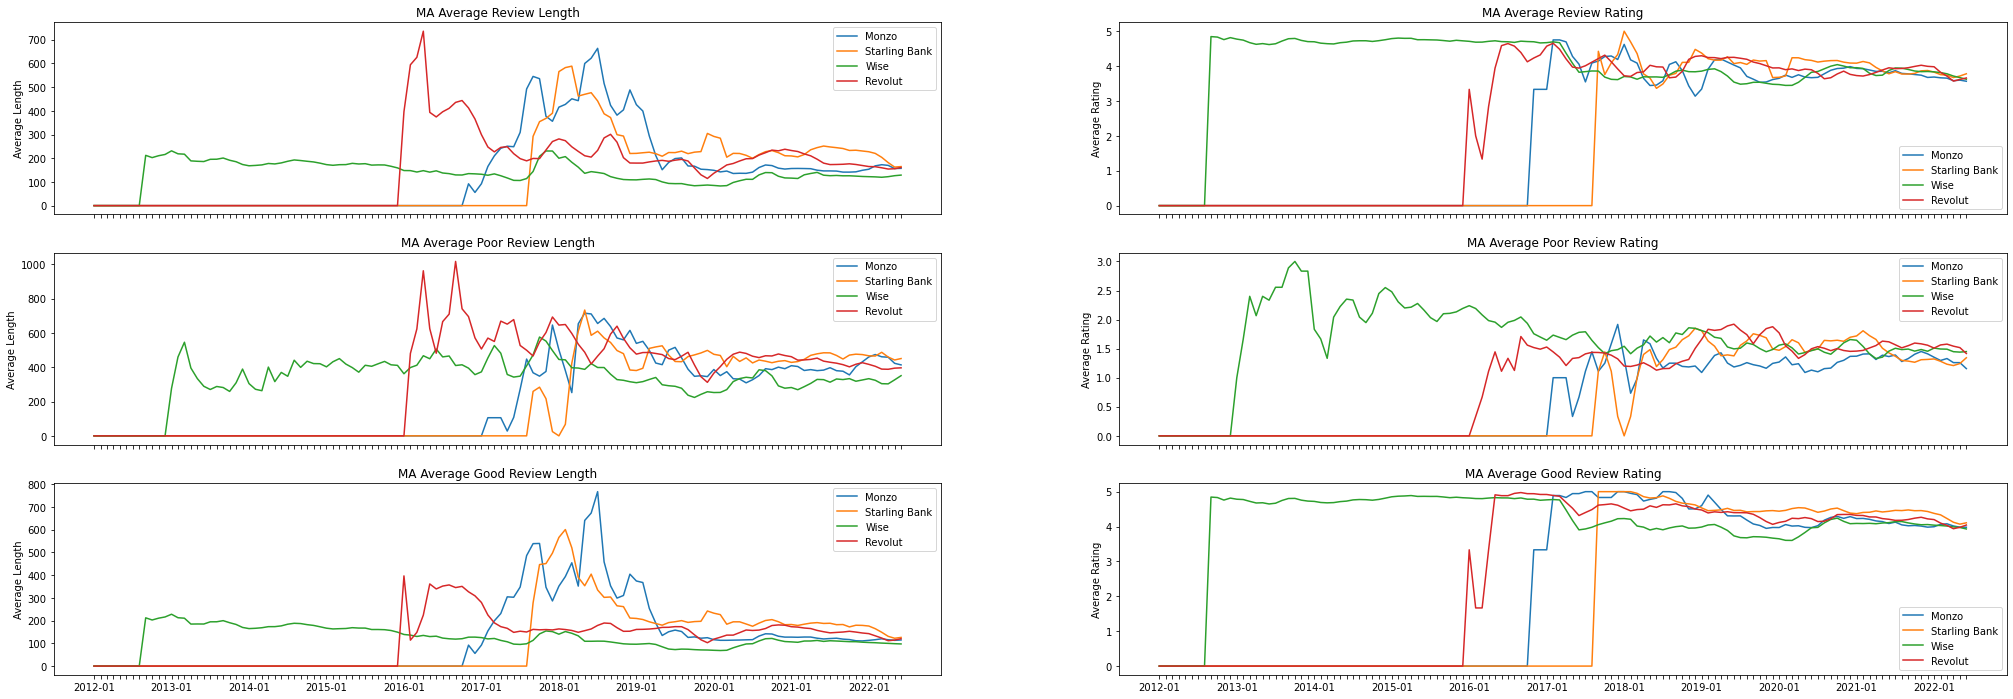

In [506]:
fig, ax = plt.subplots(3, 2, figsize=(35, 12))

ax[0,0].title.set_text('MA Average Review Length')
ax[0,0].plot(dates, monzo_avg_review_length_ma, label="Monzo")
ax[0,0].plot(dates, sb_avg_review_length_ma, label="Starling Bank")
ax[0,0].plot(dates, wise_avg_review_length_ma, label="Wise")
ax[0,0].plot(dates, rev_avg_review_length_ma, label="Revolut")
ax[0,0].legend()
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel("Average Length")

ax[0,1].title.set_text('MA Average Review Rating')
ax[0,1].plot(dates, monzo_avg_review_rating_ma, label="Monzo")
ax[0,1].plot(dates, sb_avg_review_rating_ma, label="Starling Bank")
ax[0,1].plot(dates, wise_avg_review_rating_ma, label="Wise")
ax[0,1].plot(dates, rev_avg_review_rating_ma, label="Revolut")
ax[0,1].legend()
ax[0,1].set_xticklabels([])
ax[0,1].set_ylabel("Average Rating")

ax[1,0].title.set_text('MA Average Poor Review Length')
ax[1,0].plot(dates, monzo_avg_review_length_poor_ma, label="Monzo")
ax[1,0].plot(dates, sb_avg_review_length_poor_ma, label="Starling Bank")
ax[1,0].plot(dates, wise_avg_review_length_poor_ma, label="Wise")
ax[1,0].plot(dates, rev_avg_review_length_poor_ma, label="Revolut")
ax[1,0].legend()
ax[1,0].set_xticklabels([])
ax[1,0].set_ylabel("Average Length")

ax[1,1].title.set_text('MA Average Poor Review Rating')
ax[1,1].plot(dates, monzo_avg_review_rating_poor_ma, label="Monzo")
ax[1,1].plot(dates, sb_avg_review_rating_poor_ma, label="Starling Bank")
ax[1,1].plot(dates, wise_avg_review_rating_poor_ma, label="Wise")
ax[1,1].plot(dates, rev_avg_review_rating_poor_ma, label="Revolut")
ax[1,1].legend()
ax[1,1].set_xticklabels([])
ax[1,1].set_ylabel("Average Rating")

ax[2,0].title.set_text('MA Average Good Review Length')
ax[2,0].plot(dates, monzo_avg_review_length_good_ma, label="Monzo")
ax[2,0].plot(dates, sb_avg_review_length_good_ma, label="Starling Bank")
ax[2,0].plot(dates, wise_avg_review_length_good_ma, label="Wise")
ax[2,0].plot(dates, rev_avg_review_length_good_ma, label="Revolut")
ax[2,0].legend()
ax[2,0].set_ylabel("Average Length")

ax[2,1].title.set_text('MA Average Good Review Rating')
ax[2,1].plot(dates, monzo_avg_review_rating_good_ma, label="Monzo")
ax[2,1].plot(dates, sb_avg_review_rating_good_ma, label="Starling Bank")
ax[2,1].plot(dates, wise_avg_review_rating_good_ma, label="Wise")
ax[2,1].plot(dates, rev_avg_review_rating_good_ma, label="Revolut")
ax[2,1].legend()
ax[2,1].set_ylabel("Average Rating")

every_nth = 12
for n, label in enumerate(ax[2,0].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax[2,1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [ ]:
# distribution on review lengths